# 人工知能とソフトコンピューティング 第4回 線形分類 演習
## パーセプトロンを用いた線形分類器の定義と訓練

### ステップ1
必要なモジュールをインポートする

In [1]:
from pathlib import Path # ファイルパスの取り扱い
import pandas as pd # データの取り扱い（CSVからの読み込みに利用）
from pandas import Series, DataFrame
import numpy as np # 数値計算
import matplotlib.pyplot as plt # グラフ描画
import matplotlib.cm # 描画色の管理・生成
from matplotlib.colors import ListedColormap # カラーマップ
from sklearn.metrics import accuracy_score # 分類精度
from sklearn.model_selection import train_test_split # 訓練データとテストデータの分割
from sklearn.linear_model import Perceptron # パーセプトロンオブジェクト

### ステップ2
CSVファイルからデータ（訓練データおよびテストデータ）の読み込み
* data1.csv: ランダムに二つの固まりを生成した200個の点(x,y)，どの固まりに分類されるかの正解ラベル(0, 1)付き
* data2.csv: ランダムに二つの固まりを生成した200個の点(x,y)，どの固まりに分類されるかの正解ラベル(0, 1)付き（直線で分離できそうにない）
* data3.csv: ランダムに三つの固まりを生成した300個の点(x,y)，どの固まりに分類されるかの正解ラベル(0, 1, 2)付き（直線で分離できそうにない）
* data4.csv: 課題用の訓練データ（250個の点），正解ラベル付き  
（以下参考）
* data5.csv: ランダムに三つの固まりを生成した200個の点(x,y)（直線で分離できそう）
* data6.csv: ランダムに四つの固まりを生成した1,000個の点(x,y)（直線で分離できそう）

読み込んだデータを numpy の array 形式に変換（使用するライブラリとの親和性をよくするために変換）

In [2]:
dataframe = pd.read_csv(Path("04_data", "data1.csv"))
dataframe_X = dataframe[["x", "y"]]
X = np.array(dataframe_X.values.reshape(-1, 2)) # numpy の二次元データの array に変換
t = dataframe.t.values.reshape(-1) # numpy の一次元データのarrayに変換

### ステップ3
読み込んだデータから x, y の組のデータを取り出して散布図を描画し，おおよその分布の様子を確認する．  
show_scatter() という関数を定義（2次元の点を前提とした描画関数）して呼び出している．

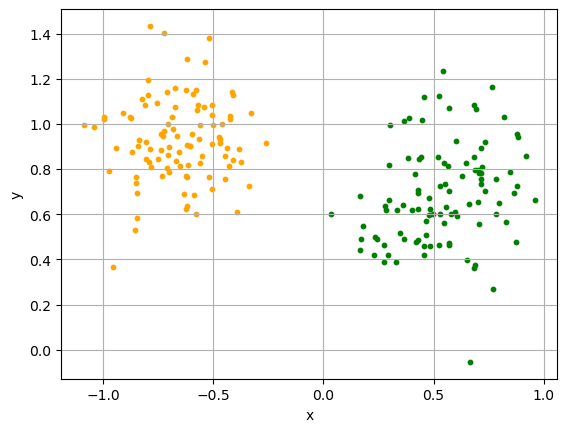

In [3]:
cmap = ("orange", "green", "cyan", "magenta", "blue", "red") # 描画の時に使う色のリスト，分類ごとに色を変える際に使用
n_classes = len(np.unique(t)) # 分類クラス数
def show_scatter(subplot, X, t, cmap, emph = False): # X: 散布表示する点（x,y) の配列，t: (x,y)がどの分類かのラベル，cmap: 色リスト，emph: 強調するか否か
    subplot.set_xlabel("x")
    subplot.set_ylabel("y")
    classes = np.unique(t) # 分類結果のラベルに出現するクラス（配列）
    for i in classes: # 正解ラベルの種類数だけ繰り返す（正解データから種類数を読み取る）
        if emph == True: # 点を強調して表示（サイズを大きくして，縁取りを付ける）
            subplot.scatter(X[t == i, 0], X[t == i, 1], marker = "o", color = cmap[i], linewidth = 1, edgecolor = "black", s = 20)
        else: # 通常表示
            subplot.scatter(X[t == i, 0], X[t == i, 1], marker = "o", color = cmap[i], s = 10)

fig = plt.figure()
subplot = fig.add_subplot()
show_scatter(subplot, X, t, cmap)
subplot.grid()
plt.show()

### ステップ4
読み込んだデータを訓練データとテストデータに分割  
テストデータの数は全体の 20% でランダムに選択  
ここで random_state = 0 としているので，乱数発生系列は毎回同じになる  
random_state = 1 とすると異なる系列で乱数が発生する
* X_train: 訓練用の (x, y) の array
* t_train: 訓練用の t (正解ラベル) の array
* X_test: テスト用の (x, y) の array
* t_test: テスト用の r (正解ラベル）の array

In [4]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size = 0.2, random_state = 0) # 訓練データとテストデータの分離

### ステップ5
分類のためのパーセプトロンオブジェクトを生成  
自分で確率的勾配降下法のプログラムを作っても良いが，ここは Scikit-learn のライブラリ Perceptron を利用
* early_stopping: 評価値に変化がない場合に，繰り返しを途中でやめる設定（True）
* n_iter_no_change: この回数分，評価値に変化がない場合に繰り返しを途中でやめる（100）
* eta0: 学習率（講義資料 p. 5 の η）（η = 1）：小さいほど早く収束する傾向

様々なデータの特徴に応じてこれらのパラメータを変化させる  
パラメータに応じて分類結果や計算時間がどうなるかを確かめる

In [5]:
early_stopping = True # EarlyStopping をするかどうか
n_iter_no_change = 100 # EarlyStopping までの繰り返し回数
eta0 = 1 # 学習率

classifier = Perceptron(early_stopping = early_stopping, n_iter_no_change = n_iter_no_change, eta0 = eta0, random_state = 0)

### ステップ6
パーセプトロン分類器を指定された Epoch 数（確率的勾配降下の回数）で学習し，重みパラメータの変化を記録する関数 fit_and_record_weight を定義
* classifier: パーセプトロン分類器
* max_iter: Epoch数（最大この回数だけ繰り返す）
* X_train: 訓練データ（ベクトル）
* X_test: テストデータ（ベクトル）
* t_train: 訓練データ（正解ラベル）
* t_test: テストデータ（正解ラベル）

In [6]:
def fit_and_record_weights(classifier, max_iter, X_train, X_test, t_train, t_test):
    classifier.set_params(max_iter = max_iter) # Perceptron のパラメータを指定（最大 epoch 数）
    classifier.fit(X_train, t_train) # 確率的勾配降下法で訓練
    n_iter = classifier.n_iter_ # 訓練が終わるまでに勾配降下計算を繰り返した数
    train_score = classifier.score(X_train, t_train) # 訓練データの分類精度
    test_score = classifier.score(X_test, t_test) # テストデータの分類精度
    weights = classifier.coef_ # 重みベクトル
    intercept = classifier.intercept_ # 切片
    return n_iter, train_score, test_score, weights, intercept

### ステップ7
パーセプトロンの学習と分類精度の評価結果の取り出し  
epoch_max 変数には最大の繰り返し数を設定（150）  
* 1回の繰り返しをする Perceptron を訓練し，その結果（精度や重み w）を記録  
* 2回の繰り返しをする Perceptron を訓練し，その結果を記録  
・・・・・
* epoch_max - 1 (149) 回の繰り返しをする Perceptron を訓練し，その結果を記録

結果として，149回分の訓練記録は配列に格納される
* train_scores: 訓練データに対する分類精度の列
* test_scores: テストデータ（訓練に使わなかったデータ）に対する分類精度の列
* w0_weights: 重みベクトルの切片（定数）要素の列
* w1_weights: 重みベクトルの x 要素の列
* w1_weights: 重みベクトルの y 要素の列

このセルを実行すると warning （=収束する前に学習をストップしている）がたくさん出ることがあるが無視して良い  
実行時間がかかるのでしばらく待つ

In [7]:
epoch_max = 150 # 最大繰り返し回数
train_scores = [] # 訓練データに対する分類精度を格納する配列（空列で初期化）
test_scores = [] # テストデータに対する分類精度を格納する配列（空列で初期化）
w1_weights = [] # 重みベクトルの要素を格納する配列（空列で初期化）
w2_weights = [] # 重みベクトルの要素を格納する配列（空列で初期化）
w0_weights = [] # 重みベクトルの要素を格納する配列（空列で初期化）
for max_iter in range(1, epoch_max): # 1～epoch_max - 1 回繰り返し
    n_iter, train_score, test_score, weights, intercept = fit_and_record_weights(classifier, max_iter, X_train, X_test, t_train, t_test) # Perceptronの訓練
    # 配列に各回の記録を格納
    train_scores.append(train_score) 
    test_scores.append(test_score)
    w0_weights.append(intercept)
    w1_weights.append(weights[:, 0])
    w2_weights.append(weights[:, 1])

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing ma

### ステップ8
訓練の経過（精度変化：訓練データ／テストデータ）の描画
* 分類精度の epoch 回数に沿った変化（訓練データ／テストデータ）
* 重みベクトルの各要素の，epoch回数に沿った変化（w0, w1, w2）

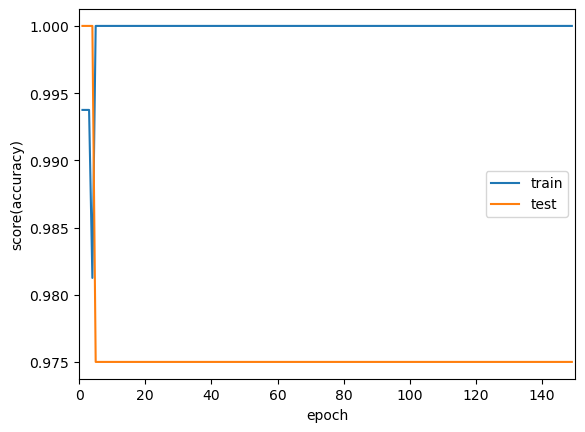

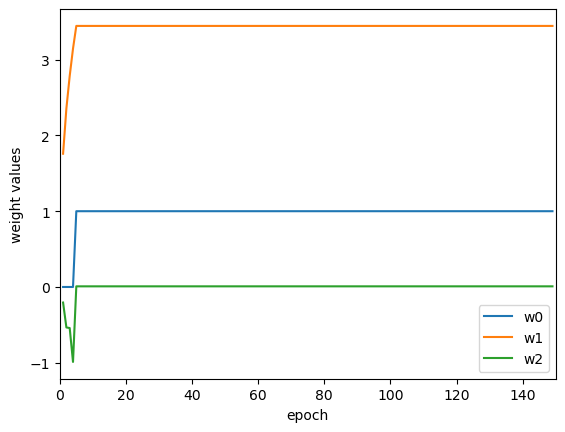

In [8]:
# 分類精度をグラフ描画する関数
def show_scores(subplot, epoch_max, train_scores, test_scores):
    subplot.set_xlim(0, epoch_max)
    subplot.set_xlabel("epoch")
    subplot.set_ylabel("score(accuracy)")
    subplot.plot(range(1, epoch_max), train_scores, label="train")
    subplot.plot(range(1, epoch_max), test_scores, label="test")
    subplot.legend()

# 重みベクトルをグラフ描画する関数
def show_weights(subplot, epoch_max, w0_weights, w1_weights, w2_weights):
    subplot.set_xlim(0, epoch_max)
    subplot.set_xlabel("epoch")
    subplot.set_ylabel("weight values")
    subplot.plot(range(1, epoch_max), w0_weights, label="w0")
    subplot.plot(range(1, epoch_max), w1_weights, label="w1")
    subplot.plot(range(1, epoch_max), w2_weights, label="w2")
    subplot.legend()

# 分類精度のグラフを描画（show_scores）を使用
fig = plt.figure()
subplot = fig.add_subplot()
show_scores(subplot, epoch_max, train_scores, test_scores)
plt.show()

# 重みベクトルのグラフを描画（計算された重みの組の数＝境界線の数）だけ表示
n_borders = len(w0_weights[0])
for i in range(0, n_borders):
    fig = plt.figure()
    subplot = fig.add_subplot()
    show_weights(subplot, epoch_max, np.array(w0_weights)[:, i], np.array(w1_weights)[:, i], np.array(w2_weights)[:, i])
    plt.show()

### ステップ9
散布図と推定した分類の境界線（一つのグループとその他を分ける境界線）を描画  
境界線のタイトルは境界線の関係式 w1 * x + w2 * y = -w0 を表示  
散布図上，テストデータには縁取りを付けて目立たせている
* first の方が確率的勾降下法の繰り返し1回後の重みに対する境界
* last の方が繰り返し150回後の重みに対する境界


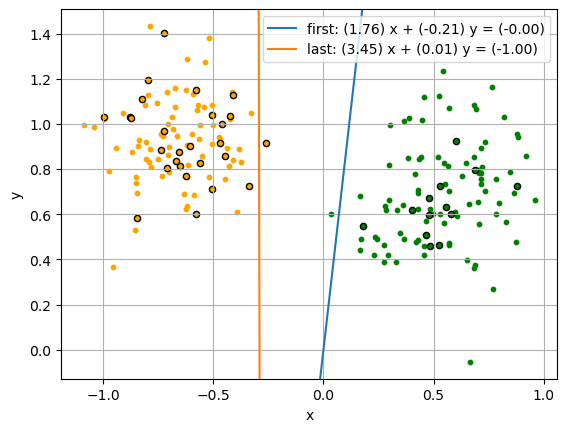

In [9]:
# グラフをプロットする範囲を計算(関数定義）
def calculate_plot_range(X_train, X_test):
    xmin, xmax = min(X_train[:, 0].min(), X_test[:, 0].min()), max(X_train[:, 0].max(), X_test[:, 0].max())
    ymin, ymax = min(X_train[:, 1].min(), X_test[:, 1].min()), max(X_train[:, 1].max(), X_test[:, 1].max())
    return xmin, xmax, ymin, ymax

# 散布図と境界線を描画する関数
def show_classification_border(subplot, xmin, xmax, ymin, ymax, w0, w1, w2, label = ""):
    # 重み，切片から x-y 平面上に分類の境界線を描画 
    linex = np.arange(xmin - 0.1 * (xmax - xmin), xmax + 0.1 * (xmax - xmin), 0.05 * (xmax - xmin))
    liney = - linex * w1 / w2 - w0 / w2
    subplot.plot(linex, liney, label = "{}: ({:=.2f}) x + ({:=.2f}) y = ({:=.2f})".format(label, w1, w2, -w0))

# 一つの境界ごとに一つの散布図との関係を表示
for i in range(0, n_borders):
    fig = plt.figure()
    subplot = fig.add_subplot()
    subplot.set_xlabel("x")
    subplot.set_ylabel("y")
    xmin, xmax, ymin, ymax = calculate_plot_range(X_train, X_test)
    # グラフの表示範囲を設定
    subplot.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin))
    subplot.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin))    
    show_classification_border(subplot, xmin, xmax, ymin, ymax, w0_weights[0][i], w1_weights[0][i], w2_weights[0][i], "first")
    show_classification_border(subplot, xmin, xmax, ymin, ymax, w0_weights[-1][i], w1_weights[-1][i], w2_weights[-1][i], "last")

    # ステップ2 で定義した show_scatter() を呼び出して散布図を表示
    show_scatter(subplot, X_train, t_train, cmap)
    show_scatter(subplot, X_test, t_test, cmap, True)
    subplot.grid()
    subplot.legend()
    plt.show()
# 複数の境界がある場合（3分類以上の場合），すべての境界線と散布図を表示
if n_borders > 1:
    fig = plt.figure()
    subplot = fig.add_subplot()
    subplot.set_xlabel("x")
    subplot.set_ylabel("y")
    for i in range(0, n_borders):
        xmin, xmax, ymin, umax = calculate_plot_range(X_train, X_test)
        subplot.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin))
        subplot.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin))
        show_classification_border(subplot, xmin, xmax, ymin, ymax, w0_weights[-1][i], w1_weights[-1][i], w2_weights[-1][i], "last")
    show_scatter(subplot, X_train, t_train, cmap)
    show_scatter(subplot, X_test, t_test, cmap, True)
    subplot.grid()
    plt.show()

## 訓練した分類器による予測

### ステップ10
ここまでに訓練した Perceptron オブジェクトに(x, y)の値を与え，その分類を出力させる  
分類を予測した出力が 0, 1, 2, ... で出力される（array形式）

In [10]:
X_predict = []
X_predict.append((0, 0)) # この値を変更して，特定の(x,y)がどのクラスに分類されるか確かめる
classifier.predict(X_predict)

array([1])

### ステップ11
平面上の点を与えて，それぞれ予測結果を出し，領域を色付けする．  
関数 show_classification_regions を定義して呼び出し

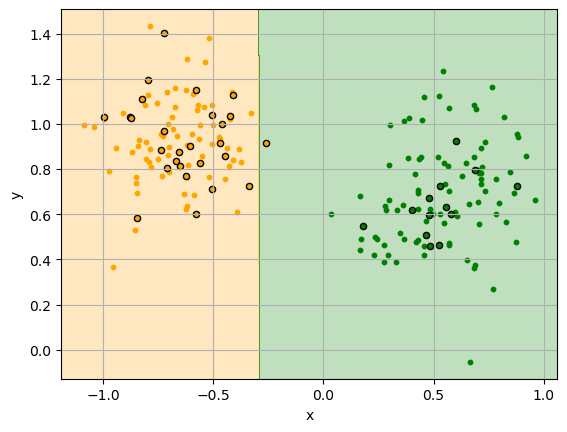

In [11]:
# 予測した結果を領域表示する関数
def show_classification_regions(classifier, subplot, X_train, X_test, t_train, t_test):
    # グラフをプロットする範囲を計算
    xmin, xmax, ymin, ymax = calculate_plot_range(X_train, X_test)
    # グラフの表示範囲を設定
    xmin, xmax, ymin, ymax = xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin), ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax -ymin)
    subplot.set_xlim(xmin, xmax)
    subplot.set_ylim(ymin, ymax)
    # 予測に与えるサンプルを取るメッシュの解像度（0.01 * (max - min)
    xres = 0.001 * (xmax - xmin)
    yres = 0.001 * (ymax - ymin)
    xmesh, ymesh = np.meshgrid(np.arange(xmin, xmax, xres), np.arange(ymin, ymax, yres)) # 等間隔で (x, y) のメッシュを作成
    Z = classifier.predict(np.array([xmesh.ravel(), ymesh.ravel()]).T) # 作成したメッシュを xの並び，yの並びにして（行列の転置）予測
    Z = Z.reshape(xmesh.shape) # 予測結果の列をサンプルの形式と合わせる
    subplot.contourf(xmesh, ymesh, Z, alpha=0.25, cmap = ListedColormap(cmap[:n_classes])) # 領域を Z の値に応じて塗りつぶし
    # ステップ2 で定義した show_scatter() を呼び出して散布図を表示
    show_scatter(subplot, X_train, t_train, cmap) # 訓練データ
    show_scatter(subplot, X_test, t_test, cmap, True) # テストデータ（強調表示する）

# 予測結果の領域表示
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_xlabel("x")
subplot.set_ylabel("y")
show_classification_regions(classifier, subplot, X_train, X_test, t_train, t_test)
subplot.grid()
plt.show()